## **Relatório - Projeto de Bioinformática**

>Neste projeto, os alunos desenvolverão um sistema para análise de sequências genéticas
>de DNA utilizando técnicas de programação paralela.
>A análise de DNA é crucial no mundo real para identificar mutações genéticas, estudar
>doenças, desenvolver tratamentos e melhorar a compreensão da biologia humana e de
>outras espécies.
>Sequências genéticas podem ter bilhões de bases, como o genoma humano, que contém
>cerca de 3 bilhões de pares de bases. Processar tais volumes de dados de forma eficiente
>exige paralelismo para reduzir significativamente o tempo de processamento e tornar a
>análise viável.


> *Todos os arquivos do tipo FASTA foram salvos na pasta arquivos_fasta, através do wget*

### Exercício 1: Contagem de Bases

**Descrição**: Implemente um programa paralelo que conte o número de ocorrências de
cada base (A, T, C, G) em uma grande cadeia de DNA.
* MPI: Divida a cadeia entre processos diferentes e agregue os resultados ao final.
Como dividir? Parte dos dados? Uma porção dos arquivos por máquina?
* OpenMP: Use paralelização em laços para distribuir a contagem entre threads.
Como consolidar a contagem? Um dicionário? Um array? Variáveis soltas?

#### Implementação 1: Paralelização com divisão de partes do arquivo entre as máquinas

Foram testadas dois tipos de paralelização, uma dividindo o arquivo entre as máquinas, lendo os arquivos na principal e gerando um vetor do tipo *char*. A função `MPI_Scatter` foi usada para dividir de forma igual o vetor entre as máquinas, as bases são contadas e a função `MPI_Reduce`é utilizada para somar as contagens locais de cada uma das bases feitas nas máquinas. Na função que conta as bases é usado `#pragma omp parallel for reduction(+:contagemLocal[:NUM_BASES])`, armazenando em um dicionário a soma da contagem que cada uma das threads fez de cada base. Foram solicitadas 4 máquinas, 4 CPU's por máquinas e 2048MB. 

**q1.sh**

~~~bash
#!/bin/bash
#SBATCH --job-name=ex1
#SBATCH --output=ex1.txt
#SBATCH --ntasks=4
#SBATCH --cpus-per-task=4
#SBATCH --mem=2048MB
#SBATCH --time=00:05:00

mpirun -np 4 ./ex1

~~~

**ex1.cpp**

~~~cpp
#include <iostream>
#include <fstream>
#include <vector>
#include <mpi.h>
#include <omp.h>
#include <cctype> 

#define NUM_BASES 4 // A, T, C, G

using namespace std;

void contarBases(const string &sequencia, int *contagemLocal) {
    #pragma omp parallel for reduction(+:contagemLocal[:NUM_BASES])
    for (size_t i = 0; i < sequencia.size(); i++) {
        char base = toupper(sequencia[i]); // Converter para maiúsculo
        switch (base) {
            case 'A': contagemLocal[0]++; break;
            case 'T': contagemLocal[1]++; break;
            case 'C': contagemLocal[2]++; break;
            case 'G': contagemLocal[3]++; break;
        }
    }
}

int main(int argc, char *argv[]) {
    int rank, numProcs;
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &numProcs);

    std::vector<char> sequencia;
    int tamPorProcesso;
    int contagemLocal[NUM_BASES] = {0}; // A, T, C, G
    int contagemGlobal[NUM_BASES] = {0};

    if (rank == 0) {
        // Leitura do arquivo FASTA
        std::ifstream arquivo("chr1.subst.fa");
        if (!arquivo.is_open()) {
            std::cerr << "Erro ao abrir o arquivo genoma.fa" << std::endl;
            MPI_Abort(MPI_COMM_WORLD, 1);
        }

        std::string linha;
        while (std::getline(arquivo, linha)) {
            if (linha[0] != '>') { // Ignorar linha de descrição
                for (char base : linha) {
                    if (base != 'N' && base != 'n') { // Ignorar caracteres 'N'
                        sequencia.push_back(base);
                    }
                }
            }
        }
        arquivo.close();

        tamPorProcesso = sequencia.size() / numProcs;
    }

    // Manda o tamanho para todos os processos
    MPI_Bcast(&tamPorProcesso, 1, MPI_INT, 0, MPI_COMM_WORLD);

    // Distribuição dos dados para cada processo
    vector<char> parteSequencia(tamPorProcesso);
    MPI_Scatter(sequencia.data(), tamPorProcesso, MPI_CHAR, parteSequencia.data(), tamPorProcesso, MPI_CHAR, 0, MPI_COMM_WORLD);

    contarBases(parteSequencia.data(), contagemLocal);

    // Redução dos resultados
    MPI_Reduce(contagemLocal, contagemGlobal, NUM_BASES, MPI_INT, MPI_SUM, 0, MPI_COMM_WORLD);

    if (rank == 0) {
        std::cout << "Contagem total de bases:" << std::endl;
        std::cout << "A: " << contagemGlobal[0] << std::endl;
        std::cout << "T: " << contagemGlobal[1] << std::endl;
        std::cout << "C: " << contagemGlobal[2] << std::endl;
        std::cout << "G: " << contagemGlobal[3] << std::endl;
    }

    MPI_Finalize();
    return 0;
}
~~~

**saida_ex1_umarquivo.txt**
~~~txt
Contagem total de bases:
A: 22799633
T: 22772026
C: 16073321
G: 16056968
O tempo de execução do programa foi de 0.823569 segundos
~~~~

Este arquivo é a saída com um apenas um arquivo FASTA, com tempo de execução de 0.823569 segundos e fazendo uma regra de três simples pensando que os arquivos possuem tamanhos semelhantes, o tempo de execução para os 22 arquivos seria de 18,118518 segundos.

#### Implementação 2: Paralelização dividindo os arquivos entre as máquinas 

Nesta abordagem a divisão ocorre atribuindo uma parte dos arquivos a cada processo, com base no número total de arquivos e processos disponíveis, de forma que cada processo processa um subconjunto de arquivos. Essa abordagem facilita a escalabilidade em sistemas distribuídos. Ao final, as contagens locais de cada processo são agregadas usando a operação `MPI_Reduce`, consolidando os resultados em um processo principal (rank 0). Por outro lado, OpenMP paraleliza os laços dentro de cada processo MPI. Durante a contagem das bases em uma sequência, a construção reduction consolida os valores de contagem em um array compartilhado (contagemLocal), garantindo a correção das operações em ambiente multi-thread.

**q1.sh**

~~~bash
#!/bin/bash
#SBATCH --job-name=ex1
#SBATCH --output=ex1.txt
#SBATCH --ntasks=4
#SBATCH --cpus-per-task=4
#SBATCH --mem=2048MB
#SBATCH --time=00:05:00

mpirun -np 4 ./ex1

~~~

**ex1_multiplos_arquivos.cpp**

~~~cpp
#include <iostream>
#include <fstream>
#include <vector>
#include <string>
#include <mpi.h>
#include <omp.h>
#include <cctype>

#define NUM_BASES 4 // A, T, C, G

using namespace std;

// Função para contar as bases de uma sequência
void contarBases(const string &sequencia, int *contagemLocal) {
    #pragma omp parallel for reduction(+:contagemLocal[:NUM_BASES])
    for (size_t i = 0; i < sequencia.size(); i++) {
        char base = toupper(sequencia[i]); // Converter para maiúsculo
        switch (base) {
            case 'A': contagemLocal[0]++; break;
            case 'T': contagemLocal[1]++; break;
            case 'C': contagemLocal[2]++; break;
            case 'G': contagemLocal[3]++; break;
        }
    }
}

// Função para processar um arquivo e retornar a sequência
string lerArquivoFASTA(const string &nomeArquivo) {
    ifstream arquivo(nomeArquivo);
    if (!arquivo.is_open()) {
        cerr << "Erro ao abrir o arquivo " << nomeArquivo << endl;
        return "";
    }

    string linha, sequencia;
    while (getline(arquivo, linha)) {
        if (linha[0] != '>') { // Ignorar linha de descrição
            for (char base : linha) {
                if (base != 'N' && base != 'n') { // Ignorar caracteres 'N'
                    sequencia += base;
                }
            }
        }
    }
    arquivo.close();
    return sequencia;
}

int main(int argc, char *argv[]) {
    int rank, numProcs;
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &numProcs);

    // Vetor de contagem local e global
    int contagemLocal[NUM_BASES] = {0};
    int contagemGlobal[NUM_BASES] = {0};

    // Lista de arquivos disponíveis
    vector<string> arquivos;
    for (int i = 1; i <= 22; i++) {
        arquivos.push_back("arquivos_fasta/chr" + to_string(i) + ".subst.fa");
    }

    // Divisão dos arquivos entre os processos
    vector<string> arquivosLocais;
    for (size_t i = rank; i < arquivos.size(); i += numProcs) {
        arquivosLocais.push_back(arquivos[i]);
    }

    double tempo_inicio = MPI_Wtime();

    // Processar os arquivos atribuídos a este processo
    for (const auto &arquivo : arquivosLocais) {
        string sequencia = lerArquivoFASTA(arquivo);
        contarBases(sequencia, contagemLocal);
    }

    double tempo_final = MPI_Wtime();
    double tempo_local = tempo_final - tempo_inicio;
    double tempo_maximo;

    // Reduzir os tempos para obter o tempo máximo
    MPI_Reduce(&tempo_local, &tempo_maximo, 1, MPI_DOUBLE, MPI_MAX, 0, MPI_COMM_WORLD);

    // Redução das contagens
    MPI_Reduce(contagemLocal, contagemGlobal, NUM_BASES, MPI_INT, MPI_SUM, 0, MPI_COMM_WORLD);

    if (rank == 0) {
        cout << "Contagem total de bases:" << endl;
        cout << "A: " << contagemGlobal[0] << endl;
        cout << "T: " << contagemGlobal[1] << endl;
        cout << "C: " << contagemGlobal[2] << endl;
        cout << "G: " << contagemGlobal[3] << endl;

        cout << "O tempo de execução do programa foi de " << tempo_maximo << " segundos." << endl;
    }

    MPI_Finalize();
    return 0;
}
~~~

**saida_ex1.txt**

~~~txt
Contagem total de bases:
A: 763517118
T: 764606176
C: 511685713
G: 511971484
O tempo de execução do programa foi de 9.04103 segundos.
~~~

**Conclusão:** O tempo estimado com a abordagem 1 é o dobro do tempo total da abordagem 2, a principal hipótese para isso ter ocorrido é que na abordagem 2 a leitura dos arquivos é divida entre as máquinas, o que pode ter gerado um maior baleanceamento de carga, não sobrecarregando o rank 0, e tendo assim mais eficiência

### Exercício 2: Transcrição de DNA em RNA

**Descrição**: Desenvolva um programa que converta uma sequência de DNA em RNA.
Lembre das substituições das bases nitrogenadas!

* MPI: Distribua a conversão entre diferentes processos e una as partes
convertidas. Será que não vale a pena salvar o RNA em arquivos? Há parte dos
dados que podemos ignorar?
* OpenMP: Paralelize a substituição em um loop, dividindo as tarefas entre threads.

#### Implementação 1: Paralelização com divisão de partes do arquivo entre as máquinas

Foi utilizado MPI e OpenMP para realizar a transcrição de uma sequência de DNA para RNA, onde timinas (T) são convertidas em uracilas (U), foi considerado que estavámos lidando com a fita molde de DNA, então apenas esse [processo deve ser feito](https://pt.khanacademy.org/science/biology/gene-expression-central-dogma/transcription-of-dna-into-rna/a/stages-of-transcription). Com MPI, o arquivo FASTA é divido entre as máquinas de forma igual. Após a transcrição, as partes processadas são reunidas no processo mestre (rank 0) por meio de `MPI_Gather`. Além disso, as bases 'N', que são ambíguas, são descartadas durante a leitura, otimizando o processamento. Para a substituição de bases no DNA, o OpenMP paraleliza o loop em cada processo, distribuindo a tarefa de conversão entre threads e garantindo maior eficiência. As bases convertidas podem ser armazenadas em um vetor compartilhado local, que é consolidado no processo mestre ao final. No final um arquivo chamado *rna_transcrito.txt*, com a sequência transcritas nesse processo. 

**q2.sh**

~~~bash
#!/bin/bash
#SBATCH --job-name=ex2
#SBATCH --output=ex2.txt
#SBATCH --ntasks=4
#SBATCH --cpus-per-task=4
#SBATCH --mem=2048MB
#SBATCH --time=00:05:00

mpirun -np 4 ./ex2

~~~

**ex2.cpp**

~~~cpp
#include <iostream>
#include <fstream>
#include <vector>
#include <mpi.h>
#include <omp.h>
#include <cctype> 

using namespace std;

void transcreveDNAparaRNA(vector<char> &sequencia) {
    #pragma omp parallel for
    for (size_t i = 0; i < sequencia.size(); i++) {
        if(sequencia[i] == 'T') {
            sequencia[i] = 'U';
        }
    }
}

int main(int argc, char *argv[]) {
    int rank, numProcs;
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &numProcs);

    vector<char> sequencia;
    int tamPorProcesso;

    // Variáveis para tempo
    double tempoInicioTotal = MPI_Wtime();
    double tempoInicioLeitura = 0.0, tempoFimLeitura = 0.0;
    double tempoInicioDistribuicao = 0.0, tempoFimDistribuicao = 0.0;
    double tempoInicioTranscricao = 0.0, tempoFimTranscricao = 0.0;
    
    if (rank == 0) {
        // Leitura do arquivo FASTA
        tempoInicioLeitura = MPI_Wtime();
        std::ifstream arquivo("arquivos_fasta/chr2.subst.fa");
        if (!arquivo.is_open()) {
            std::cerr << "Erro ao abrir o arquivo genoma.fa" << std::endl;
            MPI_Abort(MPI_COMM_WORLD, 1);
        }

        std::string linha;
        while (std::getline(arquivo, linha)) {
            if (linha[0] != '>') { // Ignorar linha de descrição
                for (char base : linha) {
                    if (base != 'N' && base != 'n') { // Ignorar caracteres 'N'
                        sequencia.push_back(toupper(base));
                    }
                }
            }
        }
        arquivo.close();

        tamPorProcesso = sequencia.size() / numProcs;
        tempoFimLeitura = MPI_Wtime();
    }

    // Manda o tamanho para todos os processos
    MPI_Bcast(&tamPorProcesso, 1, MPI_INT, 0, MPI_COMM_WORLD);

    // Distribuição dos dados para cada processo
    tempoInicioDistribuicao = MPI_Wtime();
    vector<char> parteSequencia(tamPorProcesso);
    MPI_Scatter(sequencia.data(), tamPorProcesso, MPI_CHAR, parteSequencia.data(), tamPorProcesso, MPI_CHAR, 0, MPI_COMM_WORLD);
    tempoFimDistribuicao = MPI_Wtime();

    // Transcrição de DNA para RNA
    tempoInicioTranscricao = MPI_Wtime();
    transcreveDNAparaRNA(parteSequencia);
    tempoFimTranscricao = MPI_Wtime();

    // Redução dos resultados
    MPI_Gather(parteSequencia.data(), tamPorProcesso, MPI_CHAR, sequencia.data(), tamPorProcesso, MPI_CHAR, 0, MPI_COMM_WORLD);

    if (rank == 0) {
        ofstream arquivoSaida("rna_transcrito.txt");
        if(arquivoSaida.is_open()) {
            cout << sequencia.size() << endl;
            for (char base : sequencia) {
                arquivoSaida << base;
            }
        }
        arquivoSaida.close();
        cout << "Transcrição concluída e salva em rna_transcrito.txt" << endl;
        
        // Exibindo os tempos
        double tempoTotal = MPI_Wtime() - tempoInicioTotal;
        cout << "Tempo de leitura do arquivo: " << (tempoFimLeitura - tempoInicioLeitura) << " segundos" << endl;
        cout << "Tempo de distribuição dos dados: " << (tempoFimDistribuicao - tempoInicioDistribuicao) << " segundos" << endl;
        cout << "Tempo de transcrição de DNA para RNA: " << (tempoFimTranscricao - tempoInicioTranscricao) << " segundos" << endl;
        cout << "Tempo total de execução: " << tempoTotal << " segundos" << endl;
    }

    MPI_Finalize();
    return 0;
}

~~~

**ex2_umarquivo.txt**

~~~txt
Transcrição concluída e salva em rna_transcrito.txt
Tempo de leitura do arquivo: 3.50552 segundos
Tempo de distribuição dos dados: 0.0239444 segundos
Tempo de transcrição de DNA para RNA: 0.155002 segundos
Tempo total de execução: 10.0908 segundos
~~~

Este arquivo é a saída com um apenas um arquivo FASTA, com tempo de execução total de 10.0908 segundos e fazendo uma regra de três simples pensando que os arquivos possuem tamanhos semelhantes, o tempo de execução para os 22 arquivos seria de 221,9976 segundos.

#### Implementação 2: Paralelização dividindo os arquivos entre as máquinas 

A abordagem aqui é similar a usada na segunda implementação do exercício 1, com a divisão dos 22 arquivos de forma quase igual entre as máquinas, tendo 2 máquinas com 6 arquivos e 2 máquinas com 5 arquivos. Então, cada arquivo designado para aquela máquina é lido e a sequência é salva em um vetor de caracteres. Os resultados são coletados pela função de MPI, `MPI_Gatherv`, que é usada pois como em cada processo a sequência devolvida terá um tamanho, tanto por conta da sua natureza quanto por conta dos números de bases nitrogenadas presentes, é necessário usar uma função que aceite isso. Um ponto importante para a abordagem com os dados maiores foi o tipo das variáveis dos tamanhos dos vetores, que na implementação 1 eram `int` e agora foi necessário mudar para `long long`, já que se lida com grandes números que não conseguem ser representados de forma adequada com o tipo `int`. Assim, o RNA transcrito é salvo no arquivo *rna_transcrito.txt*. 

**q2.sh**

~~~bash
#!/bin/bash
#SBATCH --job-name=ex2
#SBATCH --output=ex2.txt
#SBATCH --ntasks=4
#SBATCH --cpus-per-task=4
#SBATCH --mem=2048MB
#SBATCH --time=00:05:00

mpirun -np 4 ./ex2

~~~

**ex2_multiplos_arquivos.cpp**

~~~cpp
#include <iostream>
#include <fstream>
#include <vector>
#include <string>
#include <mpi.h>
#include <omp.h>
#include <cctype>
#include <climits>

using namespace std;

// Função para transcrever DNA para RNA
void transcreveDNAparaRNA(vector<char> &sequencia) {
    #pragma omp parallel for
    for (size_t i = 0; i < sequencia.size(); i++) {
        if (sequencia[i] == 'T') {
            sequencia[i] = 'U';
        }
    }
}

// Função para ler um arquivo FASTA e retornar a sequência
string lerArquivoFASTA(const string &nomeArquivo) {
    ifstream arquivo(nomeArquivo);
    if (!arquivo.is_open()) {
        cerr << "Erro ao abrir o arquivo " << nomeArquivo << endl;
        return "";
    }

    string linha, sequencia;
    while (getline(arquivo, linha)) {
        if (linha[0] != '>') { // Ignorar linha de descrição
            for (char base : linha) {
                if (base != 'N' && base != 'n') { // Ignorar caracteres 'N'
                    sequencia += toupper(base);
                }
            }
        }
    }
    arquivo.close();
    return sequencia;
}

// Função para salvar uma sequência em um arquivo
void salvarSequencia(const string &nomeArquivo, const string &sequencia) {
    ofstream arquivo(nomeArquivo, ios::app); // Adiciona ao arquivo existente
    if (arquivo.is_open()) {
        arquivo << sequencia << endl;
    } else {
        cerr << "Erro ao salvar no arquivo " << nomeArquivo << endl;
    }
    arquivo.close();
}

int main(int argc, char *argv[]) {
    int rank, numProcs;
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &numProcs);

    // Lista de arquivos disponíveis
    vector<string> arquivos;
    for (int i = 1; i <= 22; i++) {
        arquivos.push_back("arquivos_fasta/chr" + to_string(i) + ".subst.fa");
    }

    // Divisão de arquivos entre os processos
    vector<string> arquivosLocais;
    for (size_t i = rank; i < arquivos.size(); i += numProcs) {
        arquivosLocais.push_back(arquivos[i]);
    }

    double tempoInicioTotal = MPI_Wtime();
    double tempoLeitura = 0.0, tempoTranscricao = 0.0;

    // Transcrição de cada arquivo localmente
    string rnaTranscritoTotal;
    for (const auto &arquivo : arquivosLocais) {
        double inicioLeitura = MPI_Wtime();
        string sequencia = lerArquivoFASTA(arquivo);
        double fimLeitura = MPI_Wtime();
        tempoLeitura += fimLeitura - inicioLeitura;

        vector<char> sequenciaVec(sequencia.begin(), sequencia.end());

        double inicioTranscricao = MPI_Wtime();
        transcreveDNAparaRNA(sequenciaVec);
        double fimTranscricao = MPI_Wtime();
        tempoTranscricao += fimTranscricao - inicioTranscricao;

        rnaTranscritoTotal += string(sequenciaVec.begin(), sequenciaVec.end());
    }

    // Preparar para MPI_Gatherv
    long long localSize = rnaTranscritoTotal.size();
    vector<long long> tamanhos(numProcs, 0);

    MPI_Gather(&localSize, 1, MPI_LONG_LONG, tamanhos.data(), 1, MPI_LONG_LONG, 0, MPI_COMM_WORLD);

    vector<int> tamanhosInt(numProcs, 0); // Vetor de tamanhos para MPI_Gatherv
    vector<int> deslocamentos(numProcs, 0);
    long long totalSize = 0;

    if (rank == 0) {
        for (int i = 0; i < numProcs; i++) {
            if (tamanhos[i] > INT_MAX) {
                cerr << "Erro: Tamanho de segmento excede o limite de int!" << endl;
                MPI_Abort(MPI_COMM_WORLD, 1);
            }
            tamanhosInt[i] = static_cast<int>(tamanhos[i]);
            deslocamentos[i] = static_cast<int>(totalSize);
            totalSize += tamanhos[i];
        }
    }

    string rnaFinal;
    if (rank == 0) {
        rnaFinal.resize(totalSize);
    }

    MPI_Gatherv(
        rnaTranscritoTotal.data(), static_cast<int>(localSize), MPI_CHAR,
        rank == 0 ? rnaFinal.data() : nullptr, tamanhosInt.data(),
        deslocamentos.data(), MPI_CHAR, 0, MPI_COMM_WORLD);

    double tempoFimTotal = MPI_Wtime();
    double tempoTotal = tempoFimTotal - tempoInicioTotal;

    // O processo mestre salva o resultado no arquivo final
    if (rank == 0) {
        salvarSequencia("rna_transcrito.txt", rnaFinal);
        cout << "Transcrição concluída e salva em rna_transcrito.txt" << endl;
        cout << "Tempo total de leitura dos arquivos: " << tempoLeitura << " segundos" << endl;
        cout << "Tempo total de transcrição: " << tempoTranscricao << " segundos" << endl;
        cout << "Tempo total de execução: " << tempoTotal << " segundos" << endl;
    }

    MPI_Finalize();
    return 0;
}

~~~

**ex2.txt**

~~~txt
Transcrição concluída e salva em rna_transcrito.txt
Tempo total de leitura dos arquivos: 4.19494 segundos
Tempo total de transcrição: 1.99786 segundos
Tempo total de execução: 9.28986 segundos
~~~

#### Conclusão

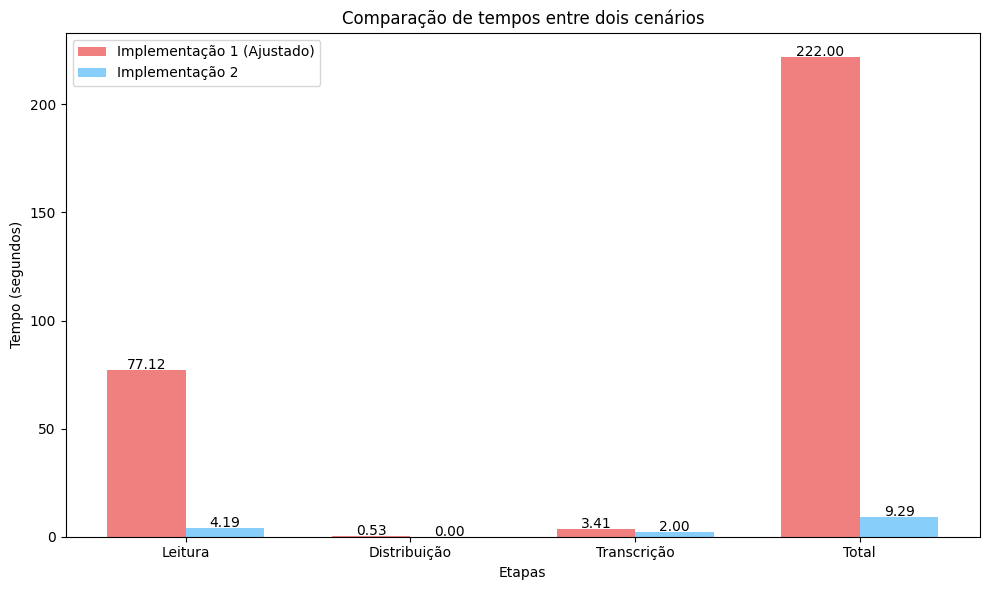

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Dados ajustados para o primeiro cenário (multiplicado por 22)
tempo_leitura_1 = 3.50552 * 22
tempo_distribuicao_1 = 0.0239444 * 22
tempo_transcricao_1 = 0.155002 * 22
tempo_total_1 = 10.0908 * 22

# Dados do segundo cenário
tempo_leitura_2 = 4.19494
tempo_transcricao_2 = 1.99786
tempo_total_2 = 9.28986

# Preparando os dados para o gráfico
labels = ["Leitura", "Distribuição", "Transcrição", "Total"]
cenario_1 = [tempo_leitura_1, tempo_distribuicao_1, tempo_transcricao_1, tempo_total_1]
cenario_2 = [tempo_leitura_2, 0, tempo_transcricao_2, tempo_total_2]

x = np.arange(len(labels))  # Posições para as barras
largura = 0.35  # Largura das barras

# Criando o gráfico
fig, ax = plt.subplots(figsize=(10, 6))
barras1 = ax.bar(x - largura/2, cenario_1, largura, label="Implementação 1 (Ajustado)", color='lightcoral')
barras2 = ax.bar(x + largura/2, cenario_2, largura, label="Implementação 2", color='lightskyblue')

# Configurações do gráfico
ax.set_xlabel("Etapas")
ax.set_ylabel("Tempo (segundos)")
ax.set_title("Comparação de tempos entre dois cenários")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adicionando os valores acima das barras
def adicionar_valores(barras):
    for barra in barras:
        altura = barra.get_height()
        ax.text(barra.get_x() + barra.get_width()/2., altura + 0.5, f'{altura:.2f}', ha='center')

adicionar_valores(barras1)
adicionar_valores(barras2)

# Exibindo o gráfico
plt.tight_layout()
plt.show()


Como podemos ver no gráfico acima a abordagem com a leitura e transcrição de diferentes arquivos nas 4 máquinas solicitadas, feita na Implementação 2. Analisando as fases que foram medidas na execução do código, pode-se ver que existe uma melhora significativa no tempo de leitura da primeira para a segunda implementação, isso pode ter acontecido justamente por essa função ocorrer em todas as máquinas, ao invés de só no rank 0. A distribuição não foi medida na segunda implementação o que pode tirar um pouco da consistência da análise. Da mesma forma, é clara a melhora, com uma redução de cerca de 96% do tempo de execução total da primeira para a segunda implementação.

### Exercício 3: Trabalhando com aminoácidos

**Descrição**: A partir da conversão de DNA → RNA, faça um programa que conte quantas
proteínas foram inicializadas (contagem de AUG). Faça a distribuição paralela que julgar
pertinente.

Utilizando MPI, o programa distribui partes da sequência de RNA, que foi salvo *rna_transcrito.txt* no exercício 2, garantindo que o cálculo seja dividido de forma equilibrada. Isso é feito inicialmente pela leitura e divisão da sequência pelo processo mestre (`rank == 0`), como foi feito nas implementações 1 dos dois primeiros exercícios, seguido pela distribuição dos blocos de dados para os processos participantes com `MPI_Scatter`. Após cada processo calcular a contagem local de códons "AUG" usando OpenMP para paralelizar o loop de contagem, os resultados são combinados no processo mestre por meio de `MPI_Reduce`. OpenMP é utilizado dentro da função `contarCodonAUG`, onde um loop paralelizado com a cláusula `reduction` acumula a contagem de códons de maneira eficiente, explorando múltiplos núcleos da CPU. 

**q3.sh**

~~~bash
#!/bin/bash
#SBATCH --job-name=ex3
#SBATCH --output=ex3.txt
#SBATCH --ntasks=4
#SBATCH --cpus-per-task=4
#SBATCH --mem=2048MB
#SBATCH --time=00:05:00

mpirun -np 4 ./ex3

~~~

**ex3.cpp**

~~~cpp
#include <iostream>
#include <fstream>
#include <vector>
#include <mpi.h>
#include <omp.h>
#include <cctype> 

using namespace std;

// Função para contar o número de códons "AUG"
int contarCodonAUG(const std::vector<char> &sequencia) {
    int count = 0;
    #pragma omp parallel for reduction(+:count)
    for (size_t i = 0; i < sequencia.size() - 2; i++) { // Verificar limite para evitar out-of-bound
        if (sequencia[i] == 'A' && sequencia[i + 1] == 'U' && sequencia[i + 2] == 'G') {
            count++;
        }
    }
    return count;
}

int main(int argc, char *argv[]) {
    int rank, numProcs;
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &numProcs);

    vector<char> sequencia;
    int tamPorProcesso;

    // Tempo de execução total
    double tempoInicioTotal = MPI_Wtime();

    double tempoInicioLeitura = 0.0, tempoFimLeitura = 0.0;
    if (rank == 0) {
        // Leitura do arquivo FASTA
        tempoInicioLeitura = MPI_Wtime();
        std::ifstream arquivo("rna_transcrito.txt");
        if (!arquivo.is_open()) {
            std::cerr << "Erro ao abrir o arquivo rna_transcrito.txt" << std::endl;
            MPI_Abort(MPI_COMM_WORLD, 1);
        }

        std::string linha;
        while (std::getline(arquivo, linha)) {
            if (linha[0] != '>') { // Ignorar linha de descrição
                for (char base : linha) {
                    if (base != 'N' && base != 'n') { // Ignorar caracteres 'N'
                        sequencia.push_back(base);
                    }
                }
            }
        }
        arquivo.close();
        tempoFimLeitura = MPI_Wtime();

        tamPorProcesso = sequencia.size() / numProcs;
    }

    // Manda o tamanho para todos os processos
    MPI_Bcast(&tamPorProcesso, 1, MPI_INT, 0, MPI_COMM_WORLD);

    // Distribuição dos dados para cada processo
    vector<char> parteSequencia(tamPorProcesso);
    MPI_Scatter(sequencia.data(), tamPorProcesso, MPI_CHAR, parteSequencia.data(), tamPorProcesso, MPI_CHAR, 0, MPI_COMM_WORLD);

    // Tempo para contar os códons
    double tempoInicioContagem = MPI_Wtime();
    int contagemLocal = contarCodonAUG(parteSequencia);
    double tempoFimContagem = MPI_Wtime();

    // Redução dos resultados
    int contagemTotal = 0;
    MPI_Reduce(&contagemLocal, &contagemTotal, 1, MPI_INT, MPI_SUM, 0, MPI_COMM_WORLD);

    double tempoFimTotal = MPI_Wtime();
    double tempoTotal = tempoFimTotal - tempoInicioTotal;

    // Processo mestre exibe os resultados e tempos
    if (rank == 0) {
        cout << "Número total de proteínas inicializadas (AUG): " << contagemTotal << endl;
        cout << "Tempo de leitura do arquivo: " << (tempoFimLeitura - tempoInicioLeitura) << " segundos" << endl;
        cout << "Tempo de contagem dos códons: " << (tempoFimContagem - tempoInicioContagem) << " segundos" << endl;
        cout << "Tempo total de execução: " << tempoTotal << " segundos" << endl;
    }

    MPI_Finalize();
    return 0;
}

~~~

**ex3.txt**
~~~txt
Número total de proteínas inicializadas (AUG): 41197534
Tempo de leitura do arquivo: 19.2232 segundos
Tempo de contagem dos códons: 2.10298 segundos
Tempo total de execução: 21.5944 segundos
~~~~

#### Conclusão

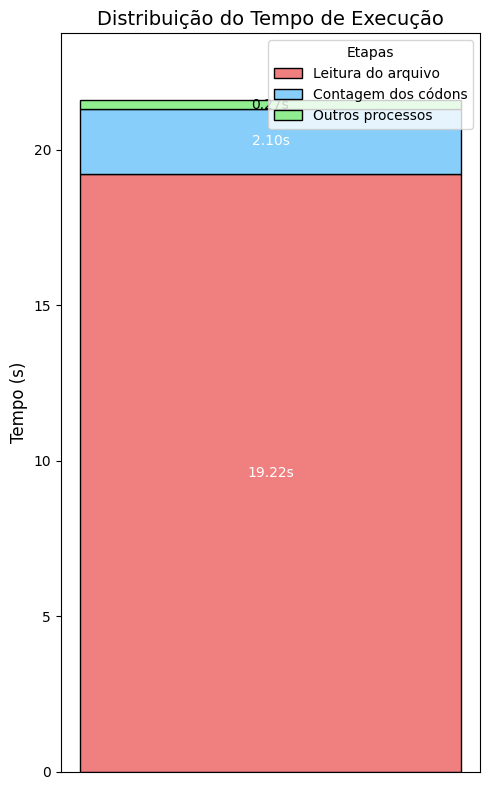

In [14]:
import matplotlib.pyplot as plt

# Dados
tempo_leitura = 19.2232
tempo_contagem = 2.10298
tempo_total = 21.5944

# Calculando os tempos restantes (caso existam)
tempo_outros = tempo_total - (tempo_leitura + tempo_contagem)

# Labels e valores para o gráfico
etapas = ["Leitura do arquivo", "Contagem dos códons", "Outros processos"]
tempos = [tempo_leitura, tempo_contagem, tempo_outros]
cores = ["lightcoral", "lightskyblue", "lightgreen"]

# Criando o gráfico
fig, ax = plt.subplots(figsize=(5, 8))

# Criando uma barra empilhada
bottom = 0  # Base inicial para empilhamento
for i, tempo in enumerate(tempos):
    ax.bar(
        "Tempo Total",
        tempo,
        color=cores[i],
        edgecolor="black",
        bottom=bottom
    )
    # Adicionando texto no centro de cada segmento
    if tempo > 0:  # Evita exibir texto para segmentos inexistentes
        ax.text(
            "Tempo Total",
            bottom + tempo / 2,
            f"{tempo:.2f}s",
            ha="center",
            va="center",
            color="white" if tempo > 1 else "black",  # Contraste
            fontsize=10
        )
    bottom += tempo  # Atualiza a base para o próximo segmento

# Ajustes visuais
ax.set_title("Distribuição do Tempo de Execução", fontsize=14)
ax.set_ylabel("Tempo (s)", fontsize=12)
ax.set_ylim(0, tempo_total * 1.1)  # Um pouco além do total para espaçamento
ax.set_xticks([])  # Remove rótulos extras do eixo x
ax.legend(etapas, loc="upper right", fontsize=10, title="Etapas")

# Exibindo o gráfico
plt.tight_layout()
plt.show()


### Exercício 4: Trabalhando com síntese proteica

**Descrição**: Desenvolva um programa que percorra uma sequência de RNA e traduza cada
códon em seu aminoácido correspondente, até encontrar um códon de parada.

* MPI: Divida a sequência de RNA em partes entre processos, cada um traduzindo
uma parte e enviando o resultado ao processo mestre para montar a proteína
completa. O que faz mais sentido? Separar por arquivos ou parte dos arquivos?
* OpenMP: Divida a tarefa entre threads para processar a tradução de forma
simultânea. O que faz mais sentido? Testar cada busca por aminoácido numa
thread?

O **MPI** é usado para dividir o trabalho entre múltiplos processos: o processo mestre (rank 0) lê a sequência completa de RNA de um arquivo, a divide entre os processos utilizando `MPI_Scatterv`, e combina os resultados dos processos com `MPI_Gatherv`. Dentro de cada processo, **OpenMP** é empregado para paralelizar o processamento da tradução da sequência local em aminoácidos, utilizando threads para acelerar o reconhecimento e a classificação dos códons. Uma abordagem crítica, `#pragma omp critical`, assegura que os resultados parciais de cada thread sejam combinados corretamente. O código usa uma inicialização de um mapa de códons (`criarMapaCodons`), o uso de buffers locais para minimizar contenções e a manipulação dinâmica de tamanhos de dados para suportar eficientemente cargas desiguais entre os processos. A saída final é salva no arquivo *aminoacidos.txt*, com a sequência de aminoácidos.

**q4.sh**

~~~bash
#!/bin/bash
#SBATCH --job-name=ex4
#SBATCH --output=ex4.txt
#SBATCH --ntasks=4
#SBATCH --cpus-per-task=4
#SBATCH --mem=2048MB
#SBATCH --time=00:05:00

mpirun -np 4 ./ex4 rna_transcrito.txt

~~~

**ex4.cpp**

~~~cpp
#include <iostream>
#include <fstream>
#include <vector>
#include <map>
#include <string>
#include <mpi.h>
#include <omp.h>

// Função para inicializar o mapa de tradução de códons para números (aminoácidos)
std::map<std::string, int> criarMapaCodons() {
    std::map<std::string, int> mapa;
    mapa["AUG"] = 1; // Metionina (início)
    mapa["CCA"] = 2; mapa["CCG"] = 2; mapa["CCU"] = 2; mapa["CCC"] = 2; // Prolina
    mapa["UCU"] = 3; mapa["UCA"] = 3; mapa["UCG"] = 3; mapa["UCC"] = 3; // Serina
    mapa["CAG"] = 4; mapa["CAA"] = 4; // Glutamina
    mapa["ACA"] = 5; mapa["ACC"] = 5; mapa["ACU"] = 5; mapa["ACG"] = 5; // Treonina
    mapa["UGC"] = 6; mapa["UGU"] = 6; // Cisteína
    mapa["GUG"] = 7; mapa["GUA"] = 7; mapa["GUC"] = 7; mapa["GUU"] = 7; // Valina
    mapa["UGA"] = 0; // Códons de parada
    return mapa;
}

// Função para ler o arquivo RNA e retornar a sequência como um vetor de caracteres
std::vector<char> lerArquivoRNA(const std::string &nomeArquivo) {
    std::ifstream arquivo(nomeArquivo);
    std::vector<char> sequencia;
    if (!arquivo.is_open()) {
        std::cerr << "Erro ao abrir o arquivo " << nomeArquivo << std::endl;
        return sequencia;
    }

    std::string linha;
    while (std::getline(arquivo, linha)) {
        for (char base : linha) {
            sequencia.push_back(base);
        }
    }
    arquivo.close();
    return sequencia;
}

std::vector<int> traduzirRNA(const std::vector<char> &sequencia, const std::map<std::string, int> &mapaCodons) {
    std::vector<int> aminoacidos;

    #pragma omp parallel
    {
        std::vector<int> localAminoacidos;
        bool localTraduzindo = false;

        #pragma omp for
        for (size_t i = 0; i < sequencia.size() - 2; i += 3) {
            std::string codon = {sequencia[i], sequencia[i + 1], sequencia[i + 2]};
            if (mapaCodons.count(codon)) {
                int aminoacido = mapaCodons.at(codon);
                if (!localTraduzindo && aminoacido == 1) { // Códon de início
                    localTraduzindo = true;
                }
                if (localTraduzindo) {
                    if (aminoacido == 0) { // Códon de parada
                        localTraduzindo = false; // Parar de traduzir nesta thread
                        continue;
                    }
                    localAminoacidos.push_back(aminoacido);
                }
            }
        }

        // Região crítica para combinar resultados
        #pragma omp critical
        aminoacidos.insert(aminoacidos.end(), localAminoacidos.begin(), localAminoacidos.end());
    }

    return aminoacidos;
}

int main(int argc, char *argv[]) {
    int rank, numProcs;
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &numProcs);

    std::vector<char> sequenciaTotal;
    std::map<std::string, int> mapaCodons = criarMapaCodons();

    double tempoInicioTotal = MPI_Wtime();

    if (rank == 0) {
        if (argc < 2) {
            std::cerr << "Uso: mpirun -np <num_procs> ./traducao_proteica <arquivo_rna>" << std::endl;
            MPI_Abort(MPI_COMM_WORLD, 1);
        }

        sequenciaTotal = lerArquivoRNA(argv[1]);
        if (sequenciaTotal.empty()) {
            std::cerr << "Erro: Arquivo vazio ou não pôde ser lido." << std::endl;
            MPI_Abort(MPI_COMM_WORLD, 1);
        }
    }

    long long tamanhoTotal = sequenciaTotal.size();
    MPI_Bcast(&tamanhoTotal, 1, MPI_LONG_LONG, 0, MPI_COMM_WORLD);

    if (tamanhoTotal == 0) {
        if (rank == 0) std::cerr << "Erro: Sequência de RNA está vazia." << std::endl;
        MPI_Finalize();
        return 1;
    }

    std::vector<int> sendCounts(numProcs, tamanhoTotal / numProcs);
    std::vector<int> displs(numProcs, 0);
    int resto = tamanhoTotal % numProcs;

    for (int i = 0; i < resto; ++i) {
        sendCounts[i]++;
    }
    for (int i = 1; i < numProcs; ++i) {
        displs[i] = displs[i - 1] + sendCounts[i - 1];
    }

    std::vector<char> sequenciaLocal(sendCounts[rank]);
    MPI_Scatterv(sequenciaTotal.data(), sendCounts.data(), displs.data(), MPI_CHAR,
                sequenciaLocal.data(), sendCounts[rank], MPI_CHAR, 0, MPI_COMM_WORLD);


    std::vector<int> aminoacidosLocais = traduzirRNA(sequenciaLocal, mapaCodons);

    int localSize = aminoacidosLocais.size();
    std::vector<int> recvCounts(numProcs, 0);
    MPI_Gather(&localSize, 1, MPI_INT, recvCounts.data(), 1, MPI_INT, 0, MPI_COMM_WORLD);

    std::vector<int> displsAminoacidos(numProcs, 0);
    if (rank == 0) {
        for (int i = 1; i < numProcs; ++i) {
            displsAminoacidos[i] = displsAminoacidos[i - 1] + recvCounts[i - 1];
        }
    }

    std::vector<int> aminoacidosFinais;
    if (rank == 0) {
        int totalSize = displsAminoacidos[numProcs - 1] + recvCounts[numProcs - 1];
        aminoacidosFinais.resize(totalSize);
    }
    MPI_Gatherv(aminoacidosLocais.data(), localSize, MPI_INT, aminoacidosFinais.data(),
                recvCounts.data(), displsAminoacidos.data(), MPI_INT, 0, MPI_COMM_WORLD);

    double tempoFimTotal = MPI_Wtime();

    if (rank == 0) {
        std::ofstream arquivoSaida("aminoacidos.txt");
        for (int aminoacido : aminoacidosFinais) {
            if (aminoacido != 0) {
                arquivoSaida << aminoacido << " ";
            }
        }
        std::cout << "Tradução concluída. Tempo total: " << (tempoFimTotal - tempoInicioTotal) << " segundos" << std::endl;
    }

    MPI_Finalize();
    return 0;
}

~~~

**ex4.txt**
~~~txt
Tempo de Leitura: 41.7485 segundos
Tempo de Distribuição: 0.19511 segundos
Tempo de Tradução: 21.8298 segundos
Tempo Total: 68.8295 segundos
~~~~

### Possíveis melhorias

Observando os tempos e quais processos dentro do código que levam mais tempos, uma das principais mudanças que poderiam ter feito é ter mantido a leitura dos arquivos distríbuida entre as threads. Para isso cada sequência de um arquivo original de DNA transcrito para RNA, poderia ficar em um arquivo próprio, fazendo com que tanto a contagem dos códons de ínicio como a transcrição de RNA para aminoácidos fosse feita com a leitura dos arquivos separadas entre as máquinas. 